In [0]:
import cv2
import numpy as np
from skimage import io
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
import numpy as np

In [0]:
def url_to_image(url):
  print("downloading %s" % (url))
  return cv2.cvtColor(io.imread(url), cv2.COLOR_BGR2RGB)
base_url = "https://raw.githubusercontent.com/mdavydov/ComputerVisionCourse/master/tasks/text/"

In [0]:
def get_text_rectangles(grayscaled, sobel_ksize=3, sobel_scale=1, sobel_delta=0, struct_elem_ksize = (17, 3)):
  sobel = cv2.Sobel(grayscaled,cv2.CV_8U,1,0,ksize=sobel_ksize, scale=sobel_scale, delta=sobel_delta)

  _, bw = cv2.threshold(sobel, 0.0, 255.0, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, struct_elem_ksize)
  connected = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel)
  _, contours, hierarchy = cv2.findContours(connected.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

  mask = np.zeros(bw.shape, dtype=np.uint8)

  rectangles = []
  for idx in range(len(contours)):
    x, y, w, h = cv2.boundingRect(contours[idx])
    mask[y:y+h, x:x+w] = 0
    cv2.drawContours(mask, contours, idx, (255, 255, 255), -1)
    r = float(cv2.countNonZero(mask[y:y+h, x:x+w])) / (w * h)

    if r > 0.45 and w > 8 and h > 8:
      rectangles.append((x,y,w,h))
  return rectangles

def show_image_with_rectangles(grayscaled, rectangles):
  img = grayscaled.copy()
  for rect in rectangles:
    (x,y,w,h) = rect
    cv2.rectangle(img, (x, y), (x+w-1, y+h-1), (0, 255, 0), 2)
  cv2_imshow(img)

In [0]:
def get_clean_rectangles(rectangles):
  non_overlapping_rectangles = []
  for i in range(len(rectangles)):
    rectangle = rectangles[i]
    (r_x,r_y,r_w,r_h) = rectangle
    r_2x = r_x + r_w
    r_2y = r_y + r_h
    unique = True
    for j in range(len(rectangles)):
      if (i == j):
        continue
      other_rectangle = rectangles[j]
      (or_x,or_y,or_w,or_h) = other_rectangle
      or_2x = or_x + or_w
      or_2y = or_y + or_h
      if (r_x >= or_x and r_y >= or_y and r_2x <= or_2x and r_2y <= or_2y):
        unique = False
        break

    if unique:
      non_overlapping_rectangles.append(rectangle)
  return non_overlapping_rectangles

In [0]:
def process_cropped_images(grayscaled, rectangles):
  for rectangle in rectangles:
    cropped_image = (grayscaled[rectangle[1]:rectangle[1]+rectangle[3], rectangle[0]:rectangle[0]+rectangle[2]]).copy()
    processed_cropped_image = process_image(cropped_image)
    grayscaled[rectangle[1]:rectangle[1]+rectangle[3], rectangle[0]:rectangle[0]+rectangle[2]] = processed_cropped_image.copy()
  return grayscaled

def process_image(grayscaled):
  blur = cv2.medianBlur(grayscaled,1)
  _, threshold = cv2.threshold(blur, 0.0, 255.0, cv2.THRESH_OTSU)
  
  colors, counts = np.unique(threshold, return_counts=True)
  black_index = np.where(colors == 0)[0][0]
  white_index = np.where(colors == 255)[0][0]
  if (counts[black_index]/counts[white_index] > 1):
    _, threshold = cv2.threshold(threshold, 150.0, 255.0, cv2.THRESH_BINARY_INV)
  return threshold

In [0]:
def is_pixel_in_rectangles(im_h,im_w,rectangles):
  for rect in rectangles:
    (x,y,w,h) = rect
    if (im_h > y and im_h < y + h and im_w > x and im_w < x + w):
      return True
  return False

def clean_non_cropped_parts(image, rectangles):
  res = image.copy()
  (im_h, im_w) = image.shape
  for i in range(im_h):
    for j in range(im_w):
      if not is_pixel_in_rectangles(i, j, rectangles):
        res[i][j] = 255
  return res

In [0]:
def separate_text(img, sobel_ksize=3, sobel_scale=1, sobel_delta=0, struct_elem_ksize = (17, 3), rectangles = None):
  if not rectangles:
    rectangles = get_text_rectangles(img, sobel_ksize, sobel_scale, sobel_delta, struct_elem_ksize)
    
  show_image_with_rectangles(img, rectangles)
  
  clean_rectangles = get_clean_rectangles(rectangles)
  show_image_with_rectangles(img, clean_rectangles)
  
  processed_image = process_cropped_images(img, clean_rectangles)
  cv2_imshow(processed_image)
  
  final_image = clean_non_cropped_parts(processed_image, clean_rectangles)
  print("RESULT:")
  cv2_imshow(final_image)

In [0]:
def prepare_image(img_string, skip_thresh=False, thresh_block_size=91, thresh_sub_mean=9, denoise_window_size=30, denoise_search_window_size=30, denoise_h=15):
  img = url_to_image(base_url + img_string)
  cv2_imshow(img)
  grayscaled = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
  if skip_thresh:
    return grayscaled
  threshold = cv2.adaptiveThreshold(grayscaled, 255,
                          cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                          cv2.THRESH_BINARY, thresh_block_size, thresh_sub_mean)
  denoised = cv2.fastNlMeansDenoising(threshold,None,denoise_window_size,denoise_search_window_size,denoise_h)
  cv2_imshow(denoised)
  return denoised

downloading https://raw.githubusercontent.com/mdavydov/ComputerVisionCourse/master/tasks/text/text1.jpg


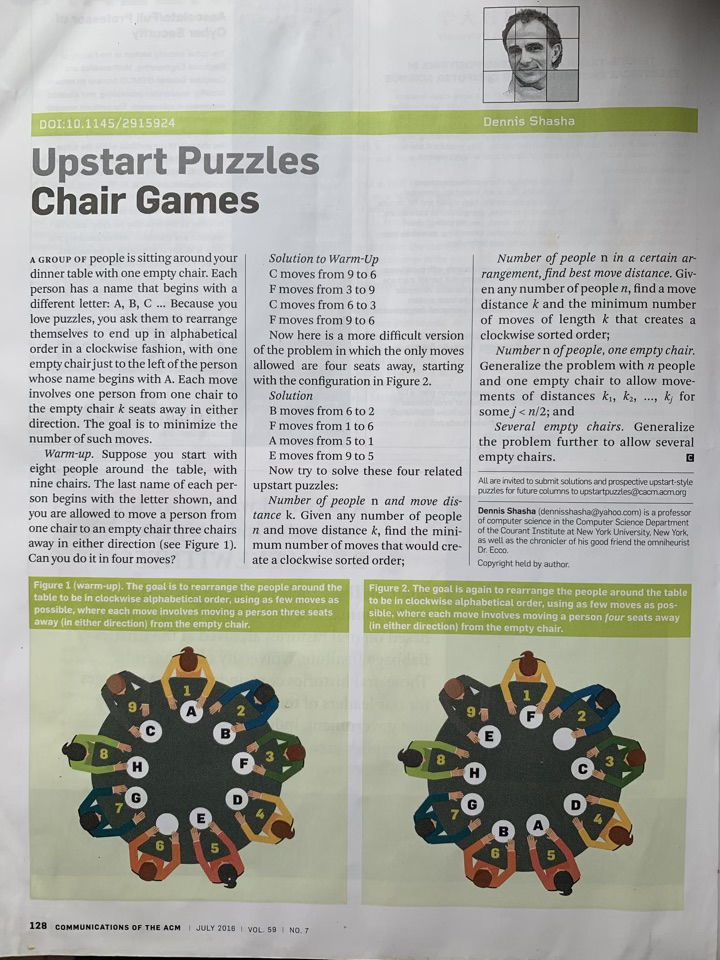

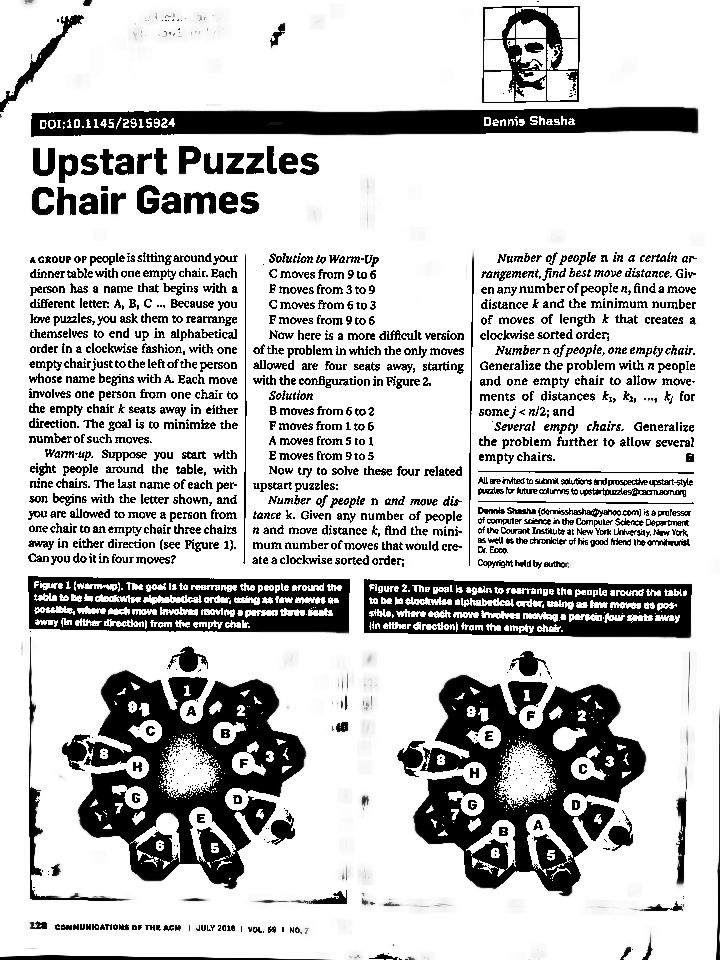

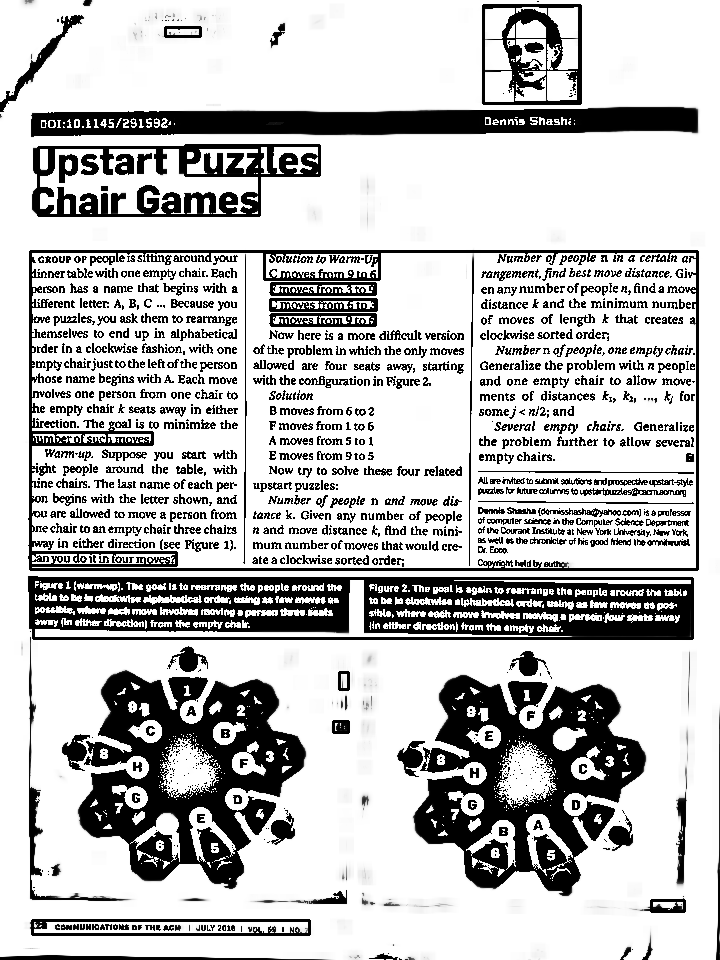

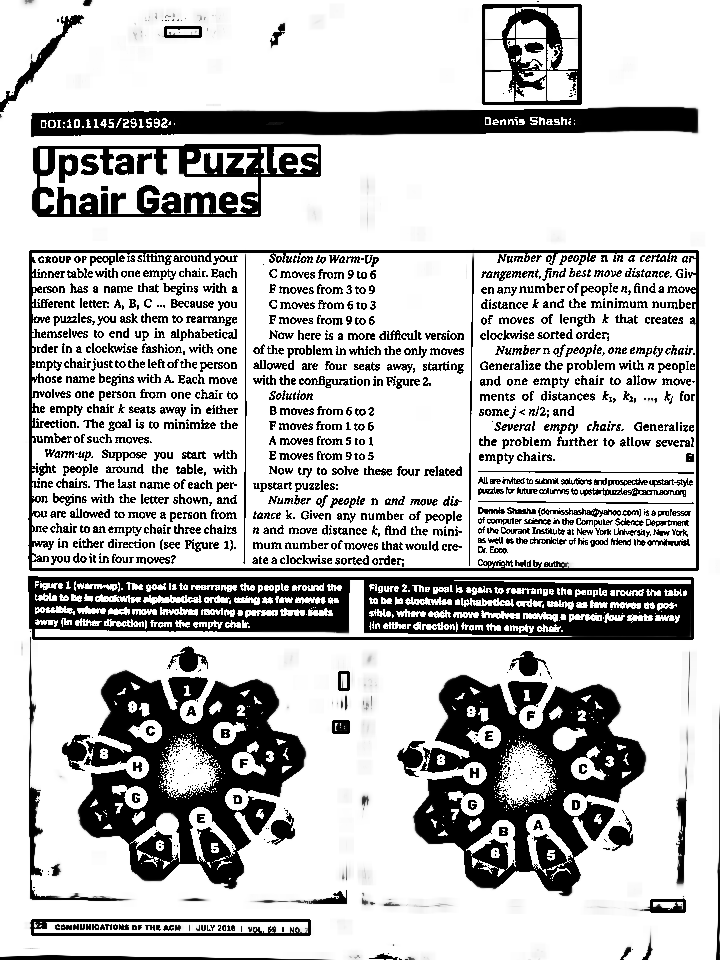

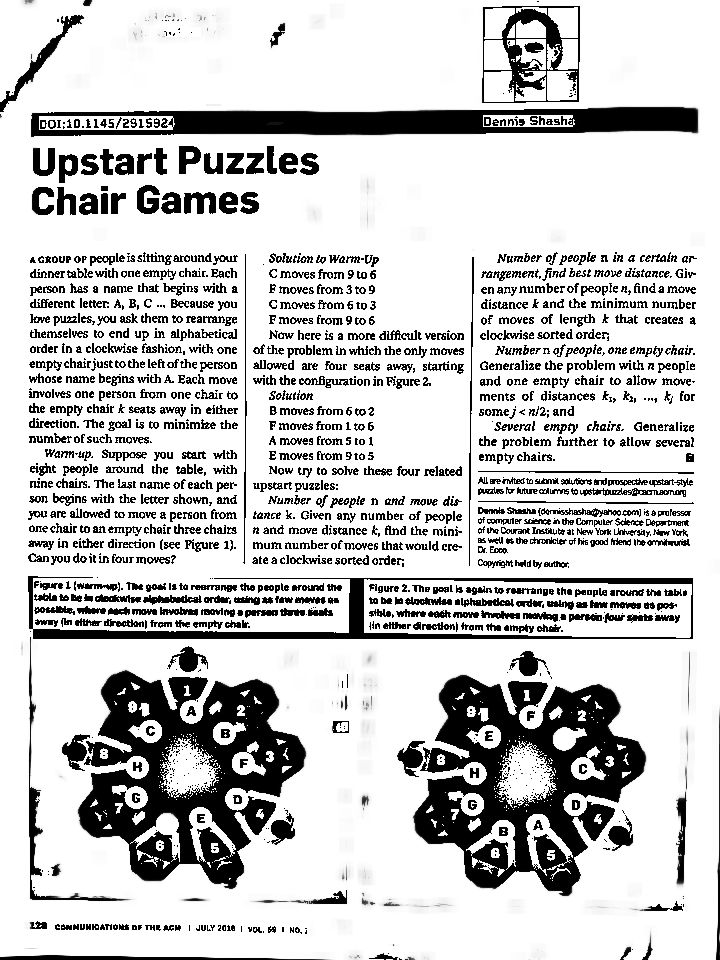

RESULT:


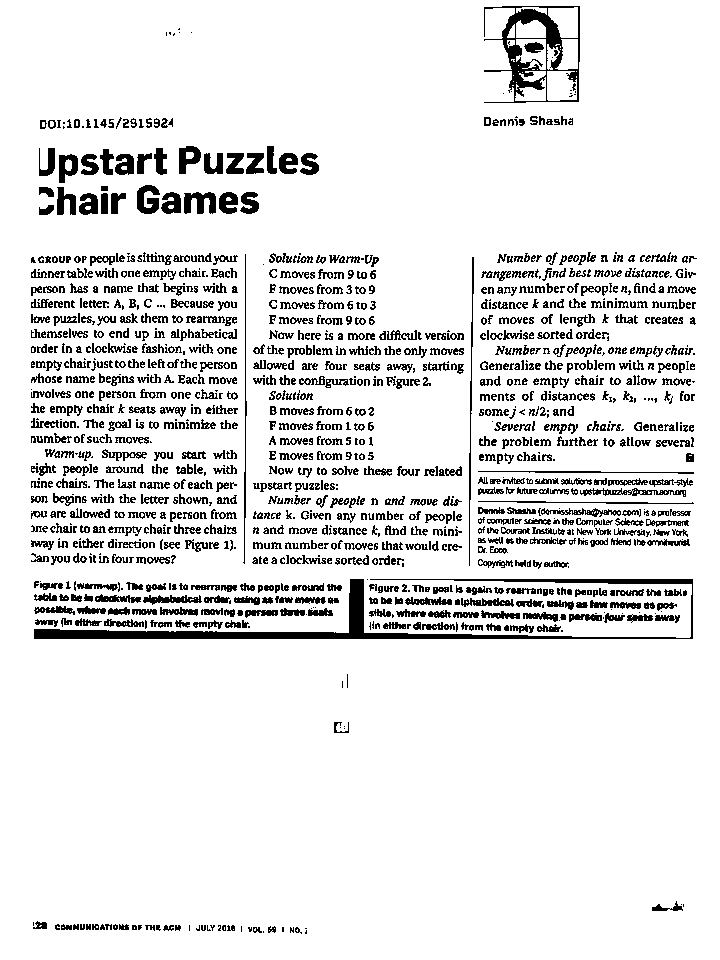

In [202]:
img = prepare_image("text1.jpg")
separate_text(img, sobel_ksize=3, sobel_scale=1, sobel_delta=0, struct_elem_ksize = (17, 3))

In [203]:
img = prepare_image("text2.jpg", skip_thresh=True, thresh_block_size=91, thresh_sub_mean=9, denoise_window_size=30, denoise_search_window_size=30, denoise_h=15)
rectangles = [(2,2,200,70),
             (202,2,200,60),
             (402,2,30,60),
             (432,2,30,60),
             (462,2,30,60),
             (492,2,20,60),
             (512,2,30,60),
             (542,2,110,55),
             (652,2,60,50),
              
             (2,78,120,20),
              
             (520,58,120,20),
             (640,55,50,20),
              
             (280,70,55,20),
              
             (335,70,45,40),
             (325,110,55,20),
             (380,70,100,50),
              
             (130,470,300,210),
             (430,470,100,210),
             (530,470,55,120),
             
             (130,810,455,90),
             (325,900,77,30),
             
             (570,910,83,30),]
separate_text(img, sobel_ksize=3, sobel_scale=1, sobel_delta=0, struct_elem_ksize = (17, 3), rectangles=rectangles)

Output hidden; open in https://colab.research.google.com to view.

downloading https://raw.githubusercontent.com/mdavydov/ComputerVisionCourse/master/tasks/text/text3.jpg


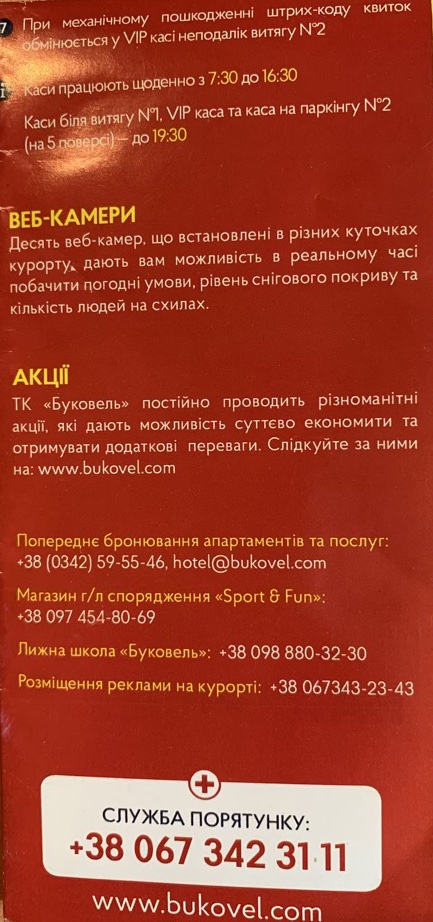

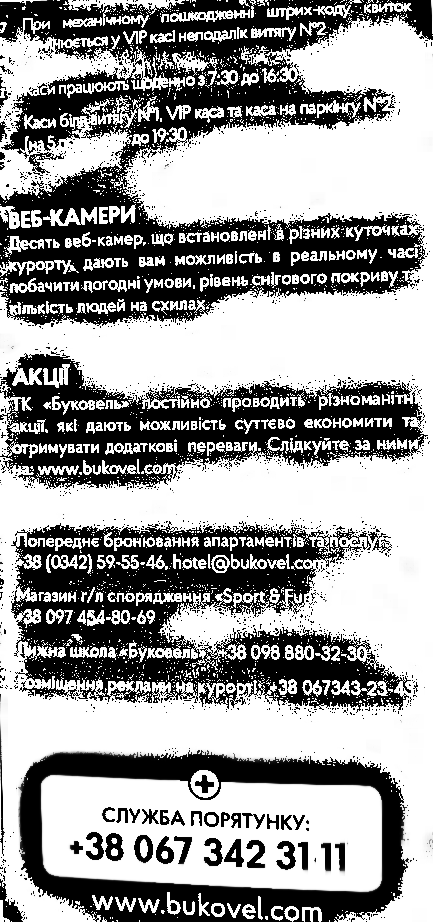

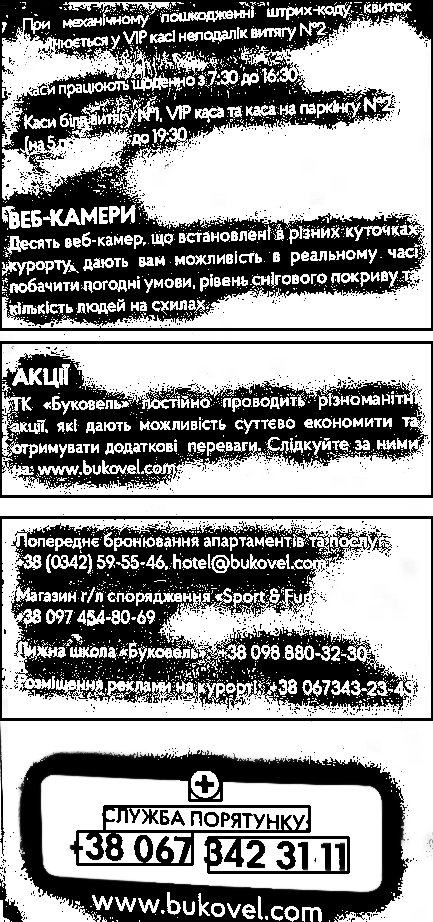

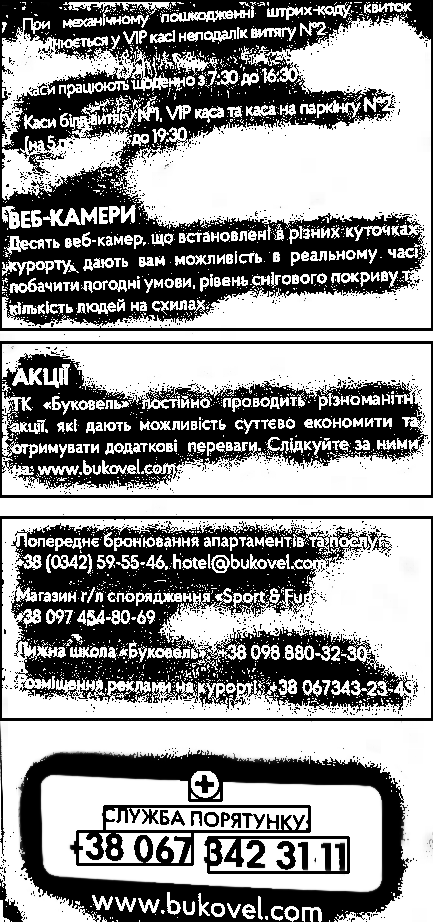

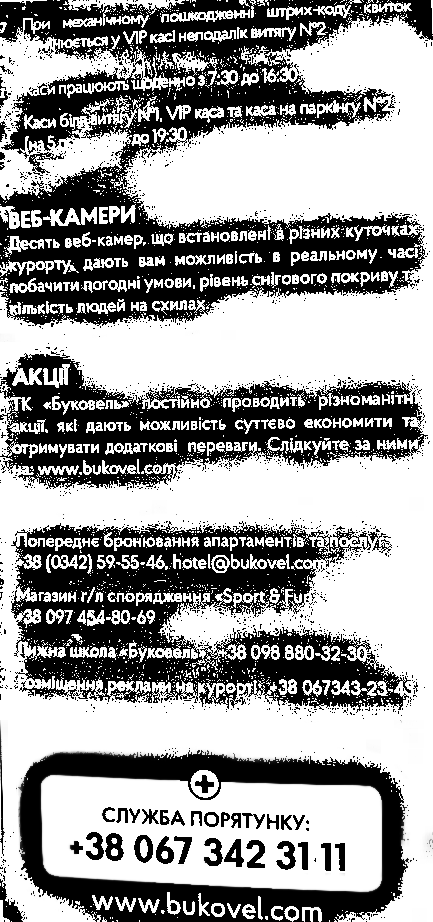

RESULT:


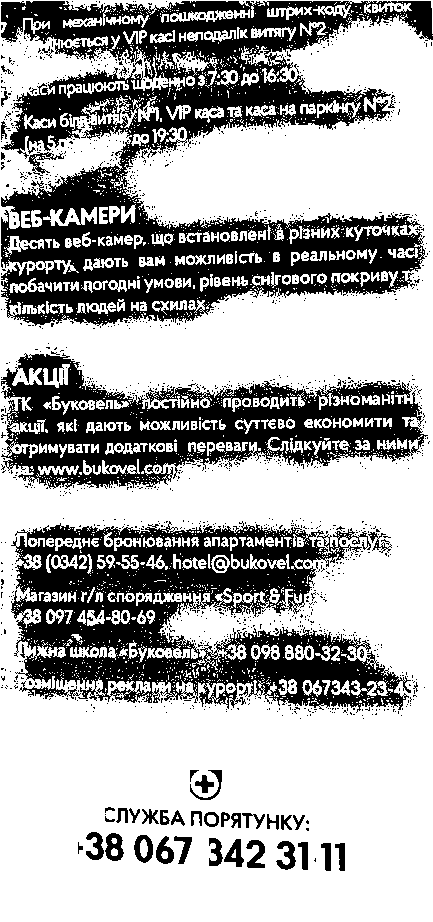

In [204]:
img = prepare_image("text3.jpg", thresh_block_size=91, thresh_sub_mean=9, denoise_window_size=30, denoise_search_window_size=30, denoise_h=15)
separate_text(img, sobel_ksize=3, sobel_scale=1, sobel_delta=0, struct_elem_ksize = (17, 3))

downloading https://raw.githubusercontent.com/mdavydov/ComputerVisionCourse/master/tasks/text/text4.jpg


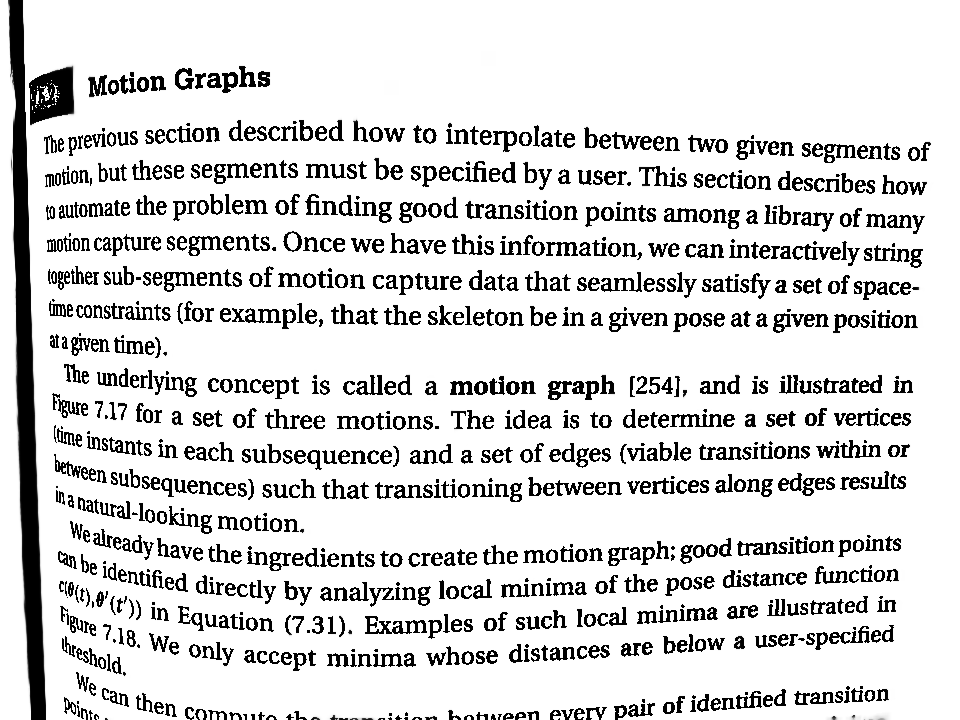

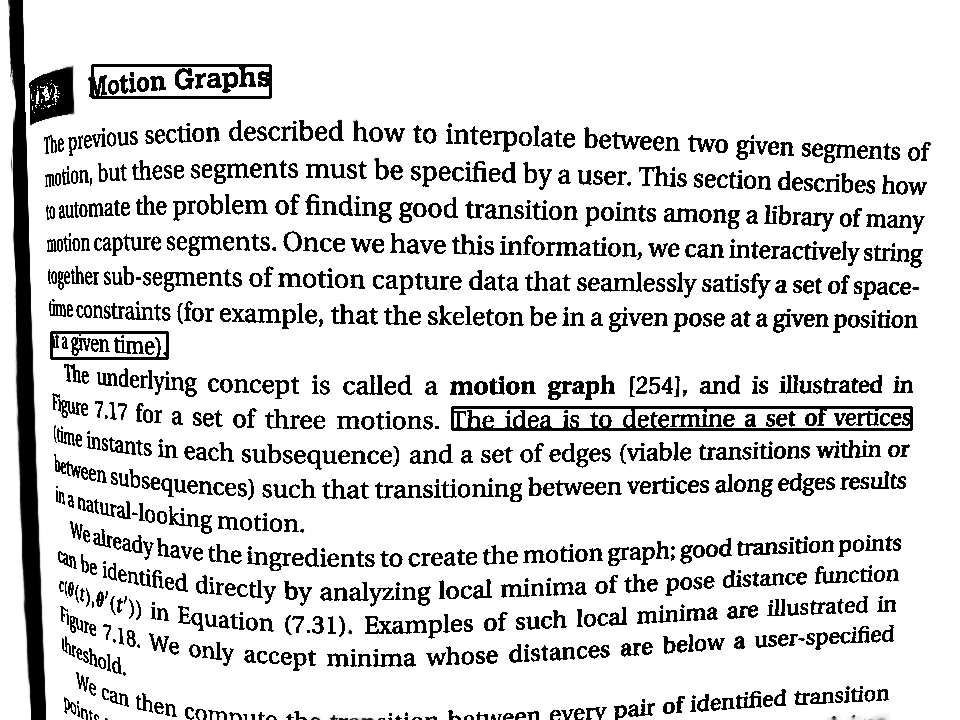

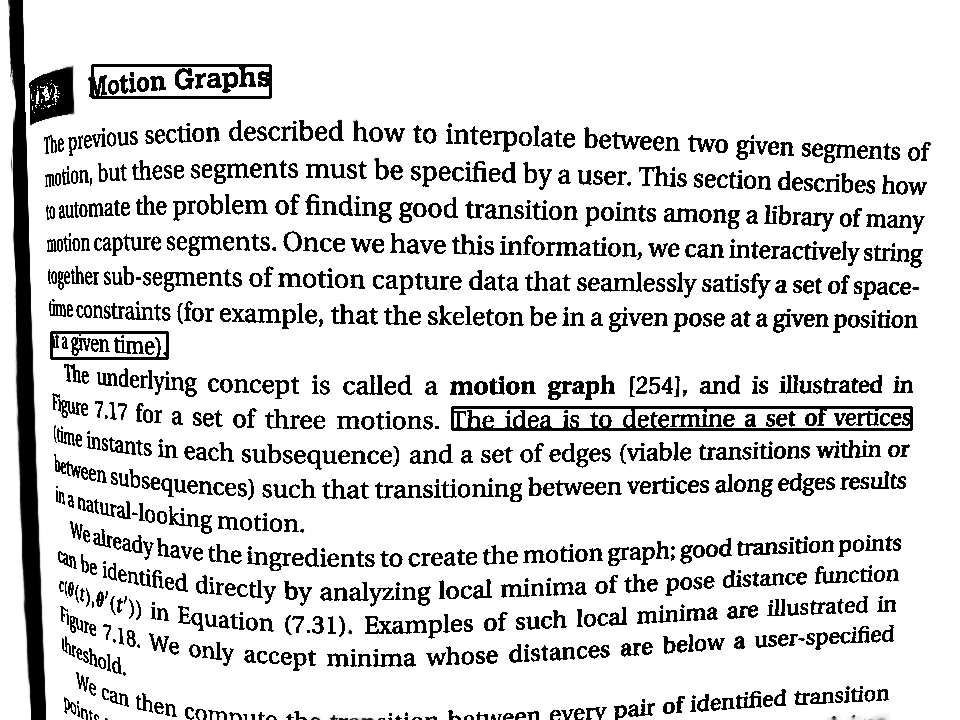

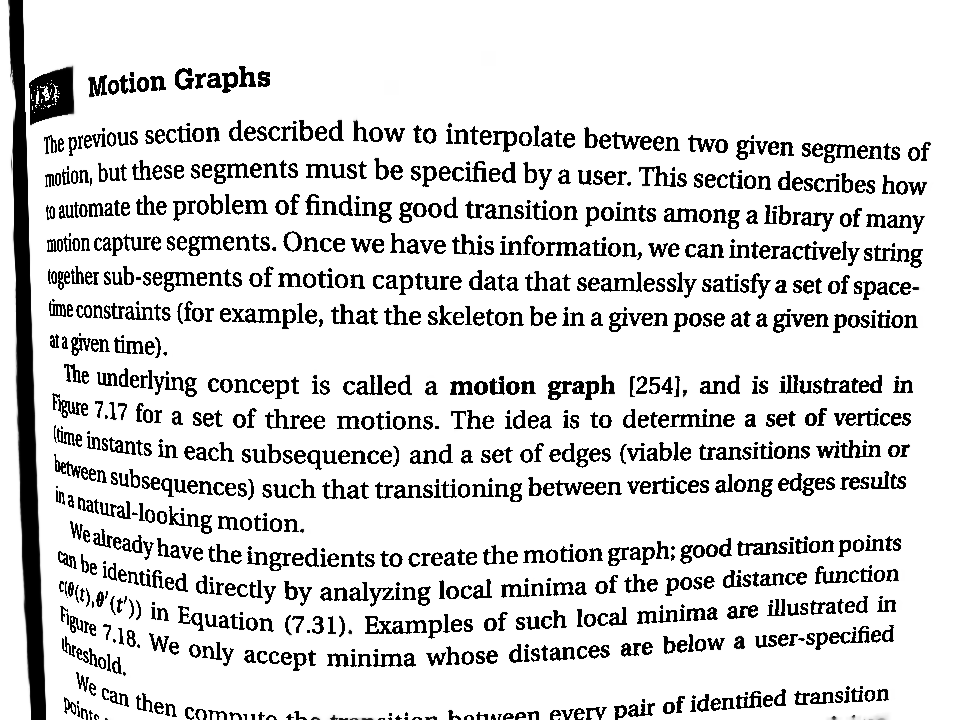

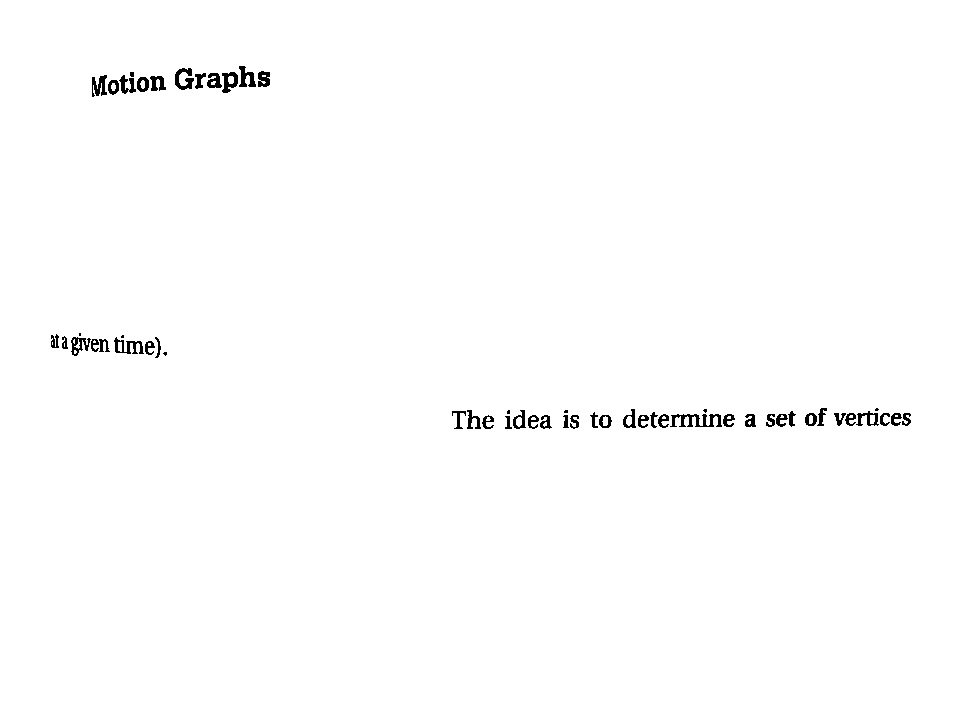

In [52]:
img = prepare_image("text4.jpg", thresh_block_size=91, thresh_sub_mean=9, denoise_window_size=30, denoise_search_window_size=30, denoise_h=15)
cv2_imshow(img)
separate_text(img, sobel_ksize=3, sobel_scale=1, sobel_delta=0, struct_elem_ksize = (17, 3))

downloading https://raw.githubusercontent.com/mdavydov/ComputerVisionCourse/master/tasks/text/text5.jpg


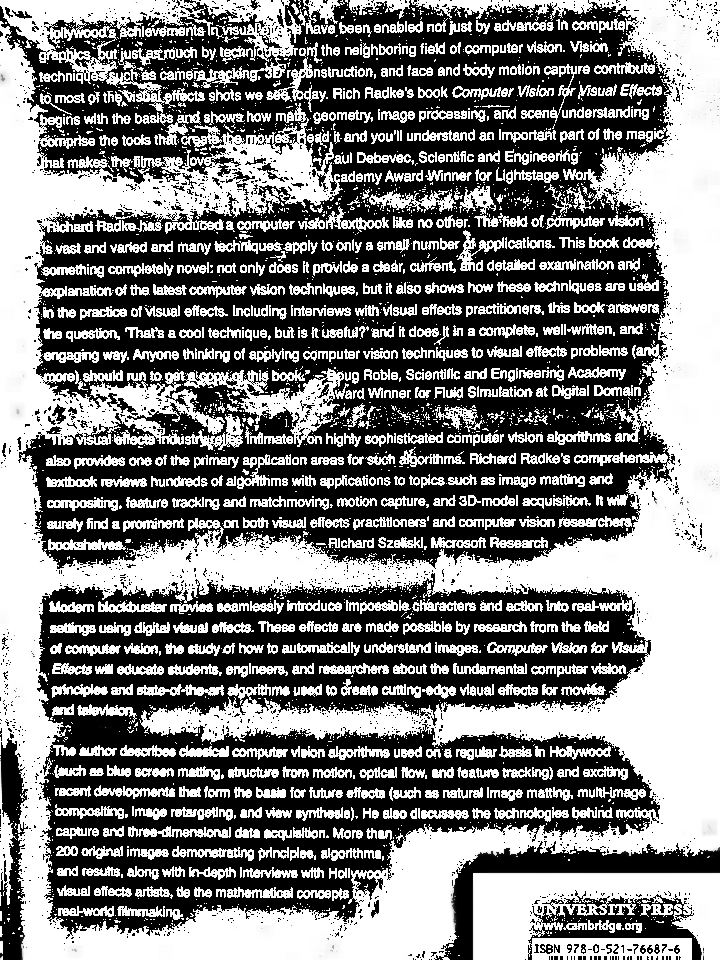

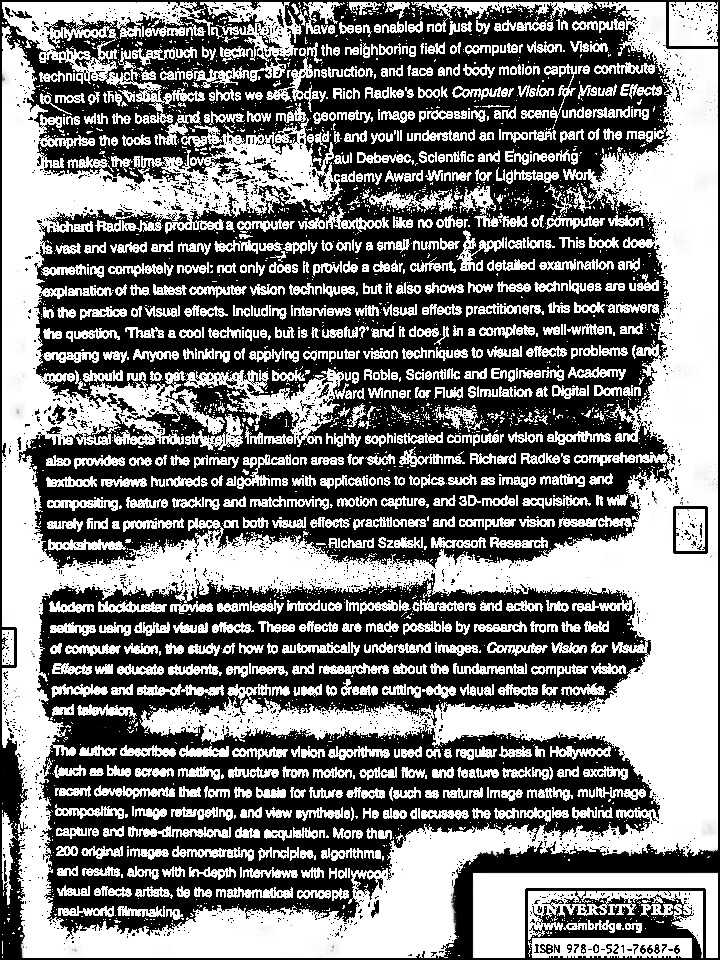

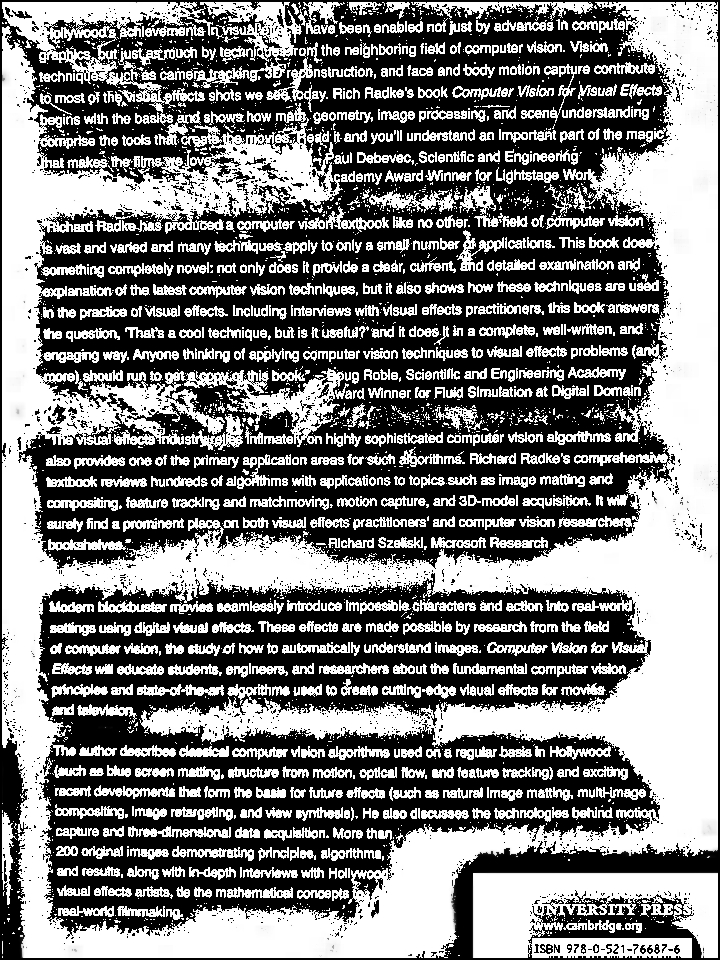

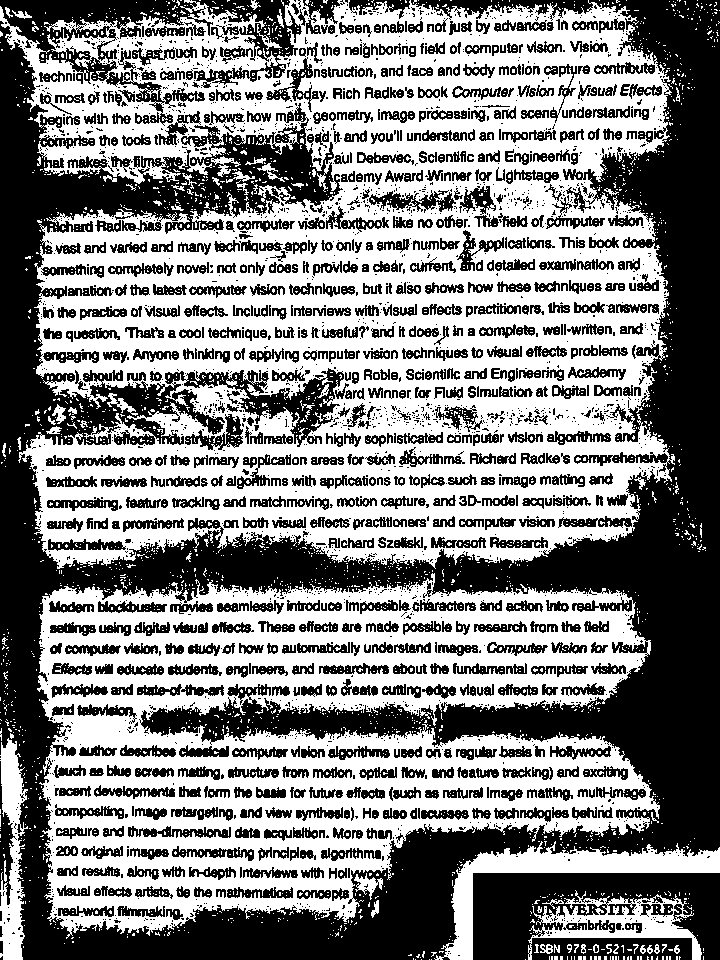

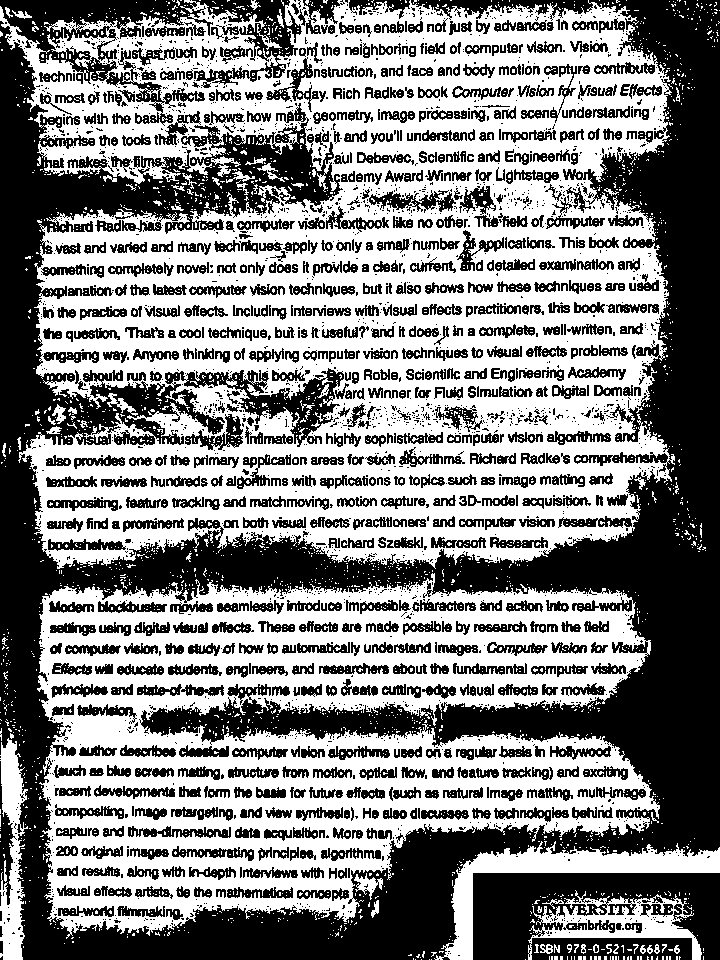

In [53]:
img = prepare_image("text5.jpg", thresh_block_size=91, thresh_sub_mean=9, denoise_window_size=30, denoise_search_window_size=30, denoise_h=15)
cv2_imshow(img)
separate_text(img, sobel_ksize=3, sobel_scale=1, sobel_delta=0, struct_elem_ksize = (17, 3))

downloading https://raw.githubusercontent.com/mdavydov/ComputerVisionCourse/master/tasks/text/text6.jpg


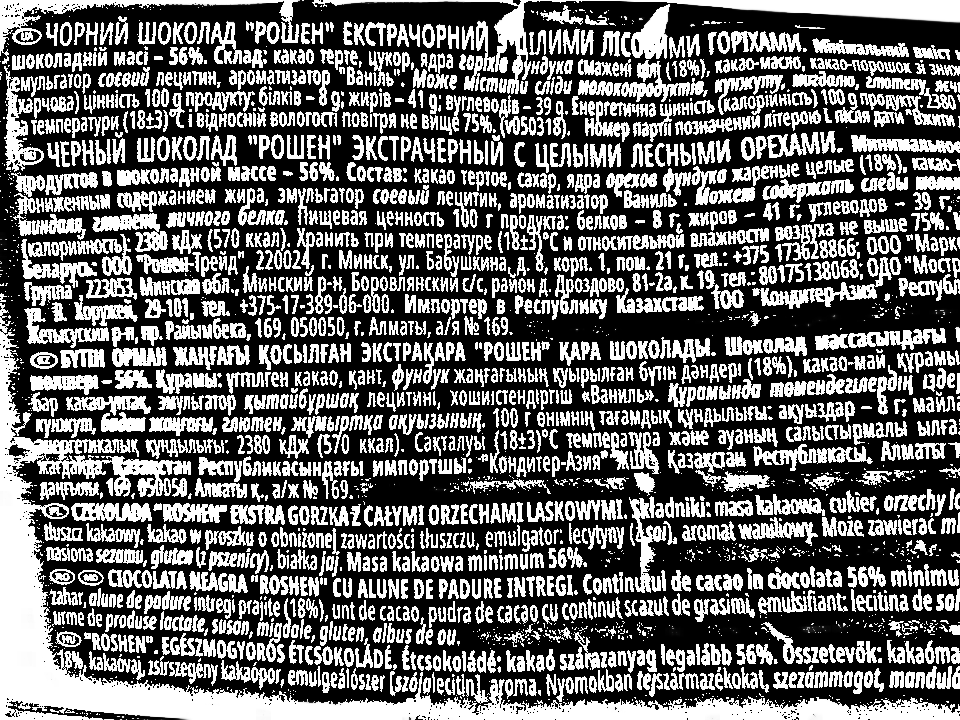

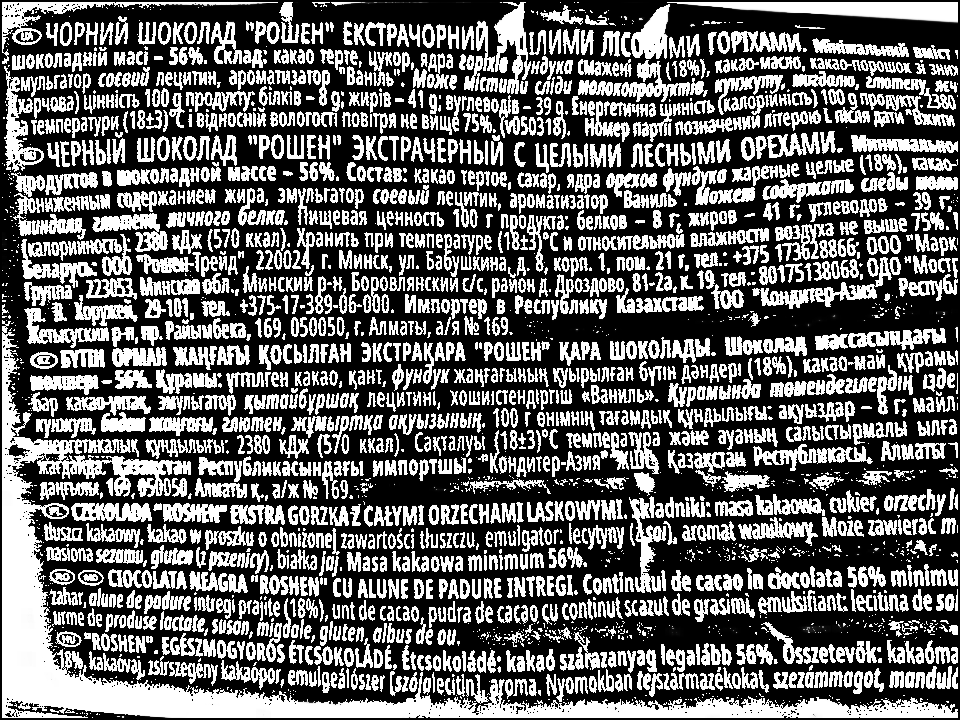

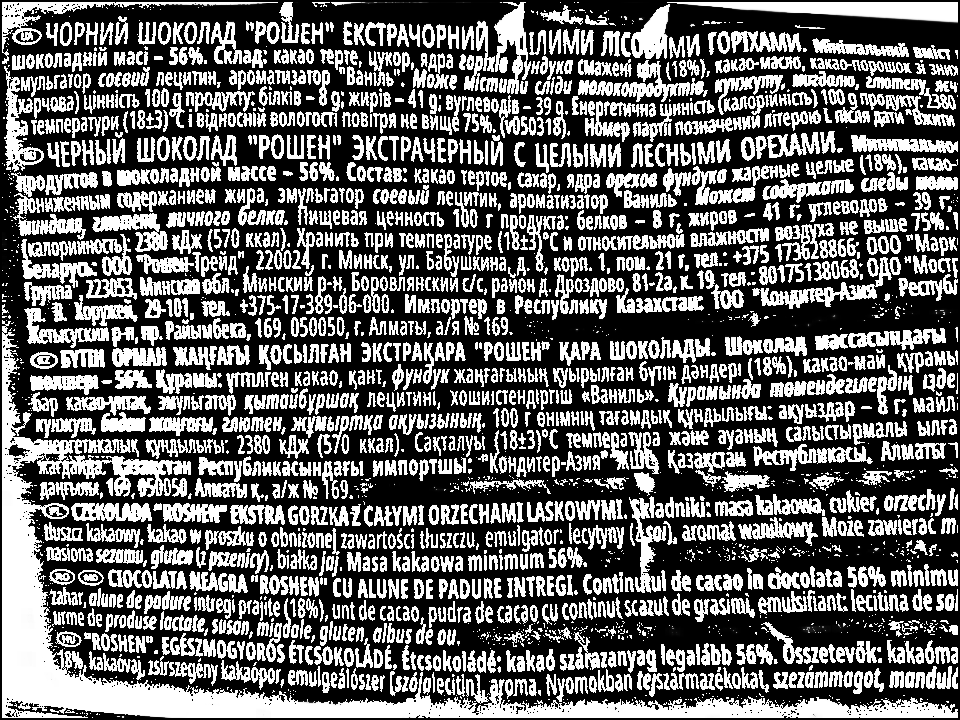

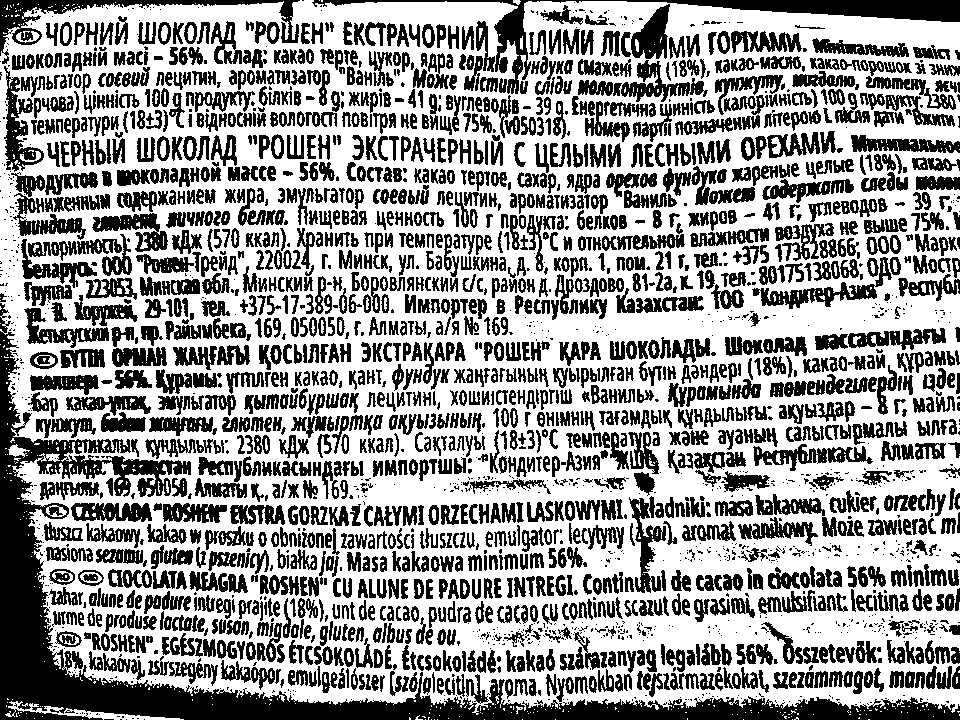

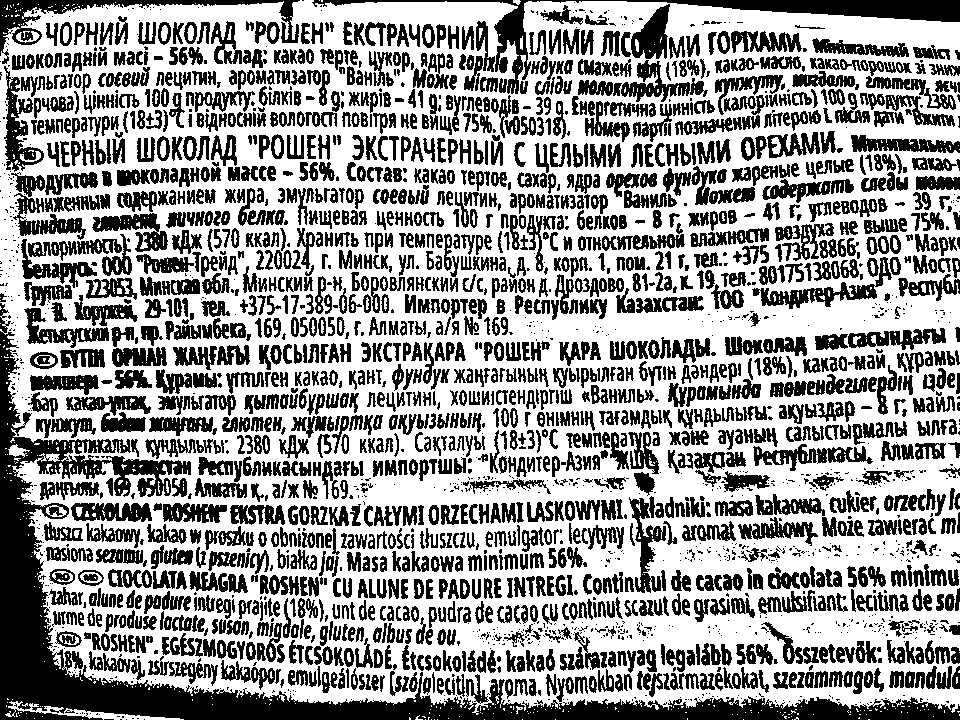

In [54]:
img = prepare_image("text6.jpg", thresh_block_size=91, thresh_sub_mean=9, denoise_window_size=30, denoise_search_window_size=30, denoise_h=15)
cv2_imshow(img)
separate_text(img, sobel_ksize=3, sobel_scale=1, sobel_delta=0, struct_elem_ksize = (17, 3))